# FAISS: So sánh các Index Types
# Index Comparison with Comprehensive Visualizations

Notebook này so sánh:
- Flat, IVF, PQ, IVF+PQ, HNSW
- Accuracy, Speed, Memory
- Trade-offs và use cases
- Recommendations cho từng scenario

In [1]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys
import os
from typing import Dict, List

sys.path.append(os.path.dirname(os.path.abspath('')))
from utils.data_generator import generate_random_vectors, generate_query_vectors
from utils.benchmark import benchmark_index, get_index_size, compare_indexes
from utils.visualization import plot_memory_usage, plot_index_comparison

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("✓ Imports hoàn tất!")

✓ Imports hoàn tất!


## 1. Setup và Data Generation

In [2]:
# Configuration
dimension = 128
n_vectors = 100000
n_queries = 200
k = 10

print(f"Configuration:")
print(f"  Dimension: {dimension}")
print(f"  Database: {n_vectors:,} vectors")
print(f"  Queries: {n_queries}")
print(f"  k: {k}")

# Generate data
np.random.seed(42)
database_vectors = generate_random_vectors(n_vectors, dimension)
query_vectors = generate_query_vectors(n_queries, dimension)

print(f"\n✓ Data ready")
print(f"  Database size: {database_vectors.nbytes / (1024**2):.2f} MB")

Configuration:
  Dimension: 128
  Database: 100,000 vectors
  Queries: 200
  k: 10

✓ Data ready
  Database size: 48.83 MB


## 2. Build All Indexes

In [3]:
print("Building all indexes...\n")

indexes = {}
build_times = {}

# 1. Flat Index
print("[1/5] Building Flat Index...")
start = time.time()
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(database_vectors)
build_times['Flat'] = time.time() - start
indexes['Flat'] = index_flat
print(f"  ✓ Build time: {build_times['Flat']:.3f}s\n")

# 2. IVF Index
print("[2/5] Building IVF Index...")
nlist = int(np.sqrt(n_vectors))
start = time.time()
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index_ivf.train(database_vectors)
index_ivf.add(database_vectors)
index_ivf.nprobe = 10
build_times['IVF'] = time.time() - start
indexes['IVF'] = index_ivf
print(f"  ✓ Build time: {build_times['IVF']:.3f}s")
print(f"  ✓ nlist={nlist}, nprobe=10\n")

# 3. PQ Index
print("[3/5] Building PQ Index...")
m = 8  # number of sub-vectors
nbits = 8  # bits per sub-vector
start = time.time()
index_pq = faiss.IndexPQ(dimension, m, nbits)
index_pq.train(database_vectors)
index_pq.add(database_vectors)
build_times['PQ'] = time.time() - start
indexes['PQ'] = index_pq
print(f"  ✓ Build time: {build_times['PQ']:.3f}s")
print(f"  ✓ m={m}, nbits={nbits}\n")

# 4. IVF+PQ Index
print("[4/5] Building IVF+PQ Index...")
start = time.time()
quantizer_ivfpq = faiss.IndexFlatL2(dimension)
index_ivfpq = faiss.IndexIVFPQ(quantizer_ivfpq, dimension, nlist, m, nbits)
index_ivfpq.train(database_vectors)
index_ivfpq.add(database_vectors)
index_ivfpq.nprobe = 10
build_times['IVF+PQ'] = time.time() - start
indexes['IVF+PQ'] = index_ivfpq
print(f"  ✓ Build time: {build_times['IVF+PQ']:.3f}s")
print(f"  ✓ nlist={nlist}, m={m}, nprobe=10\n")

# 5. HNSW Index
print("[5/5] Building HNSW Index...")
M = 32
start = time.time()
index_hnsw = faiss.IndexHNSWFlat(dimension, M)
index_hnsw.hnsw.efConstruction = 40
index_hnsw.add(database_vectors)
index_hnsw.hnsw.efSearch = 16
build_times['HNSW'] = time.time() - start
indexes['HNSW'] = index_hnsw
print(f"  ✓ Build time: {build_times['HNSW']:.3f}s")
print(f"  ✓ M={M}, efConstruction=40, efSearch=16\n")

print("="*70)
print("All indexes built successfully!")
print("="*70)

Building all indexes...

[1/5] Building Flat Index...
  ✓ Build time: 0.121s

[2/5] Building IVF Index...
  ✓ Build time: 2.202s
  ✓ nlist=316, nprobe=10

[3/5] Building PQ Index...
  ✓ Build time: 2.244s
  ✓ m=8, nbits=8

[4/5] Building IVF+PQ Index...
  ✓ Build time: 4.319s
  ✓ nlist=316, m=8, nprobe=10

[5/5] Building HNSW Index...
  ✓ Build time: 12.215s
  ✓ M=32, efConstruction=40, efSearch=16

All indexes built successfully!


## 3. Get Ground Truth

In [4]:
# Use Flat index as ground truth
print("Getting ground truth from Flat index...")
gt_distances, gt_indices = index_flat.search(query_vectors, k)
print(f"✓ Ground truth ready")

Getting ground truth from Flat index...
✓ Ground truth ready


## 4. Benchmark All Indexes

In [5]:
# Benchmark each index
print("\nBenchmarking all indexes...\n")

results = {}
memory_sizes = {}

for name, index in indexes.items():
    print(f"Benchmarking {name}...")
    
    # Benchmark
    bench_results = benchmark_index(index, query_vectors, k, gt_indices)
    
    # Get memory size
    size_info = get_index_size(index)
    
    # Store
    results[name] = {
        'recall': bench_results[f'recall@{k}'],
        'qps': bench_results['qps'],
        'search_time': bench_results['search_time'],
        'build_time': build_times[name],
        'size_mb': size_info['size_mb']
    }
    memory_sizes[name] = size_info['size_mb']
    
    print(f"  Recall: {bench_results[f'recall@{k}']:.3f}")
    print(f"  QPS: {bench_results['qps']:.1f}")
    print(f"  Size: {size_info['size_mb']:.2f} MB")
    print()

print("✓ Benchmarking complete!")


Benchmarking all indexes...

Benchmarking Flat...
  Recall: 1.000
  QPS: 1015.8
  Size: 48.83 MB

Benchmarking IVF...
  Recall: 0.198
  QPS: 7256.3
  Size: 49.75 MB

Benchmarking PQ...
  Recall: 0.058
  QPS: 2751.5
  Size: 0.89 MB

Benchmarking IVF+PQ...
  Recall: 0.052
  QPS: 45466.7
  Size: 1.81 MB

Benchmarking HNSW...
  Recall: 0.212
  QPS: 31161.2
  Size: 74.79 MB

✓ Benchmarking complete!


## 5. Comprehensive Comparison Table

In [6]:
# Create detailed comparison table
print("\n" + "="*90)
print("COMPREHENSIVE INDEX COMPARISON".center(90))
print("="*90)
print(f"{'Index':<12} {'Recall':<10} {'QPS':<12} {'Build(s)':<10} {'Size(MB)':<10} {'Compression':<12}")
print("-"*90)

baseline_size = results['Flat']['size_mb']
for name, data in results.items():
    compression = baseline_size / data['size_mb']
    print(f"{name:<12} "
          f"{data['recall']:<10.3f} "
          f"{data['qps']:<12.1f} "
          f"{data['build_time']:<10.3f} "
          f"{data['size_mb']:<10.2f} "
          f"{compression:<12.1f}x")

print("="*90)


                              COMPREHENSIVE INDEX COMPARISON                              
Index        Recall     QPS          Build(s)   Size(MB)   Compression 
------------------------------------------------------------------------------------------
Flat         1.000      1015.8       0.121      48.83      1.0         x
IVF          0.198      7256.3       2.202      49.75      1.0         x
PQ           0.058      2751.5       2.244      0.89       55.0        x
IVF+PQ       0.052      45466.7      4.319      1.81       27.0        x
HNSW         0.212      31161.2      12.215     74.79      0.7         x


## 6. Visualization - Multi-metric Comparison

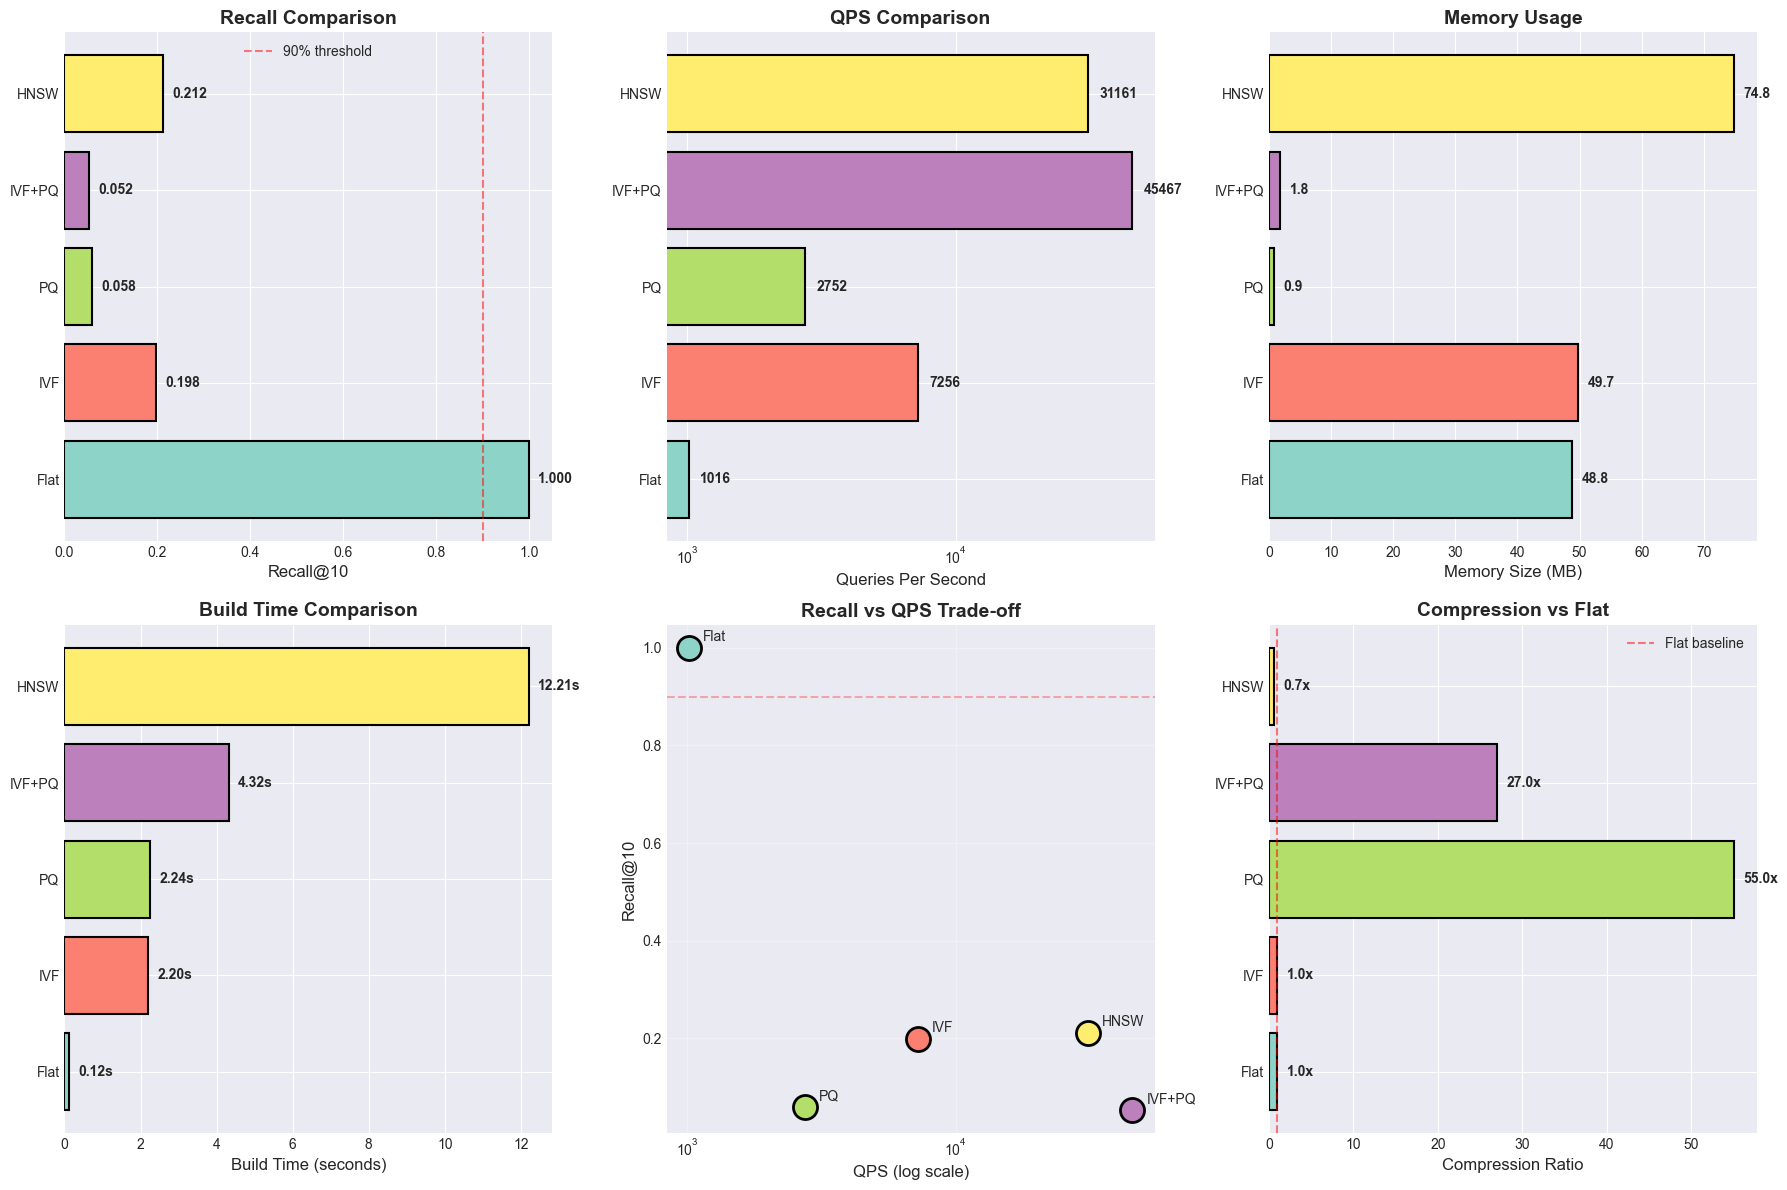

✓ Đã lưu: 03_comprehensive_comparison.png


In [7]:
# Multi-panel comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

index_names = list(results.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(index_names)))

# Plot 1: Recall
ax = axes[0, 0]
recalls = [results[name]['recall'] for name in index_names]
bars = ax.barh(index_names, recalls, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Recall@10', fontsize=12)
ax.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1.05])
ax.axvline(0.9, color='red', linestyle='--', alpha=0.5, label='90% threshold')
ax.legend()
for i, (bar, val) in enumerate(zip(bars, recalls)):
    ax.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

# Plot 2: QPS
ax = axes[0, 1]
qps_values = [results[name]['qps'] for name in index_names]
bars = ax.barh(index_names, qps_values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Queries Per Second', fontsize=12)
ax.set_title('QPS Comparison', fontsize=14, fontweight='bold')
ax.set_xscale('log')
for i, (bar, val) in enumerate(zip(bars, qps_values)):
    ax.text(val * 1.1, i, f'{val:.0f}', va='center', fontweight='bold')

# Plot 3: Memory Size
ax = axes[0, 2]
sizes = [results[name]['size_mb'] for name in index_names]
bars = ax.barh(index_names, sizes, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Memory Size (MB)', fontsize=12)
ax.set_title('Memory Usage', fontsize=14, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, sizes)):
    ax.text(val + max(sizes)*0.02, i, f'{val:.1f}', va='center', fontweight='bold')

# Plot 4: Build Time
ax = axes[1, 0]
build_times_list = [results[name]['build_time'] for name in index_names]
bars = ax.barh(index_names, build_times_list, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Build Time (seconds)', fontsize=12)
ax.set_title('Build Time Comparison', fontsize=14, fontweight='bold')
for i, (bar, val) in enumerate(zip(bars, build_times_list)):
    ax.text(val + max(build_times_list)*0.02, i, f'{val:.2f}s', va='center', fontweight='bold')

# Plot 5: Recall vs QPS scatter
ax = axes[1, 1]
for i, name in enumerate(index_names):
    ax.scatter(results[name]['qps'], results[name]['recall'], 
               s=300, color=colors[i], edgecolors='black', linewidth=2,
               label=name, zorder=5)
    ax.annotate(name, (results[name]['qps'], results[name]['recall']),
                xytext=(10, 5), textcoords='offset points', fontsize=10)
ax.set_xlabel('QPS (log scale)', fontsize=12)
ax.set_ylabel('Recall@10', fontsize=12)
ax.set_title('Recall vs QPS Trade-off', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.axhline(0.9, color='red', linestyle='--', alpha=0.3)

# Plot 6: Compression ratio
ax = axes[1, 2]
compressions = [baseline_size / results[name]['size_mb'] for name in index_names]
bars = ax.barh(index_names, compressions, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Compression Ratio', fontsize=12)
ax.set_title('Compression vs Flat', fontsize=14, fontweight='bold')
ax.axvline(1.0, color='red', linestyle='--', alpha=0.5, label='Flat baseline')
ax.legend()
for i, (bar, val) in enumerate(zip(bars, compressions)):
    ax.text(val + max(compressions)*0.02, i, f'{val:.1f}x', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('03_comprehensive_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 03_comprehensive_comparison.png")

## 7. Spider/Radar Chart - Overall Performance

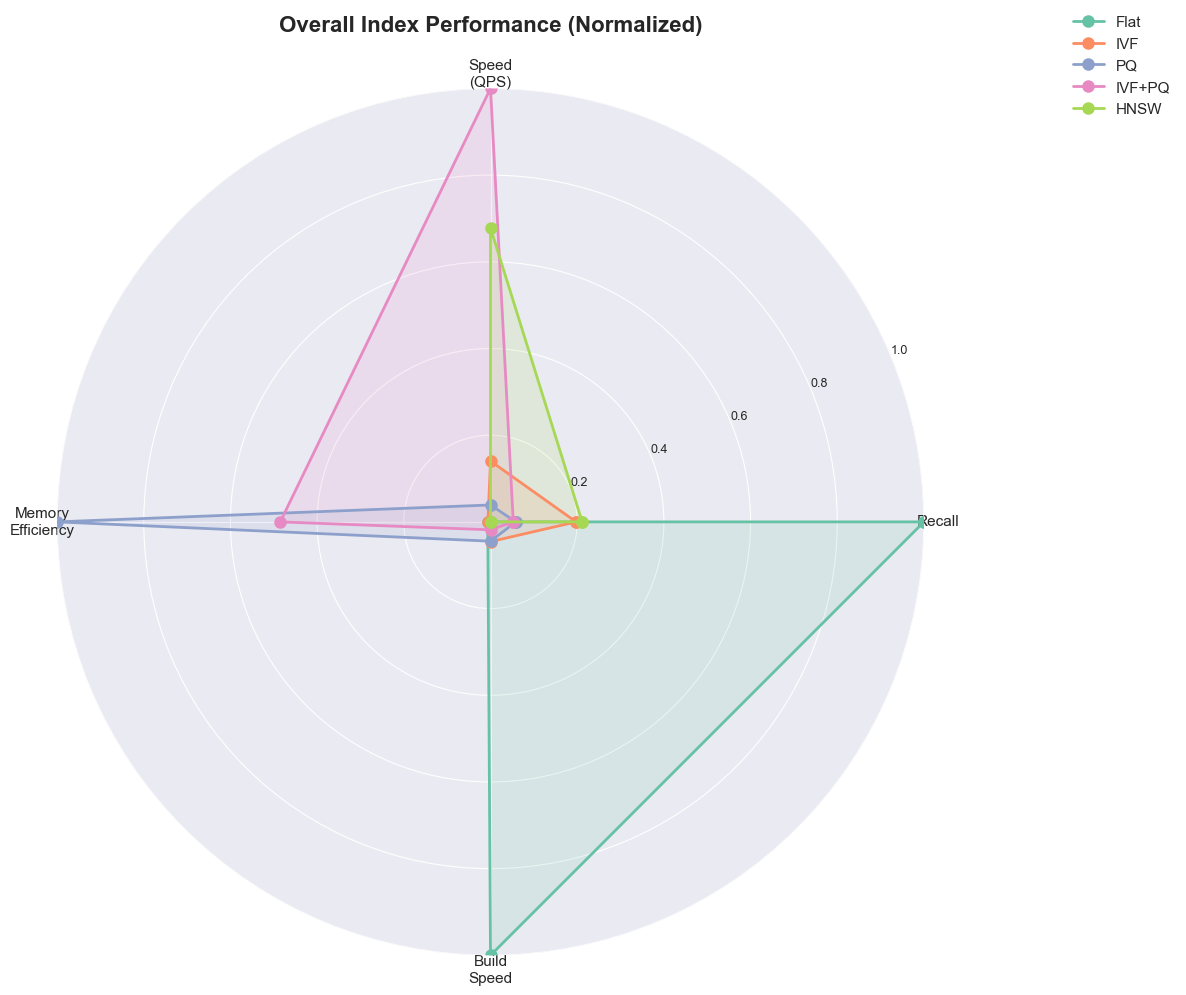

✓ Đã lưu: 03_radar_comparison.png


In [8]:
# Normalize metrics for radar chart (0-1 scale, higher is better)
def normalize_metric(values, higher_is_better=True):
    arr = np.array(values)
    if not higher_is_better:
        arr = 1 / (arr + 1e-10)  # Invert for metrics where lower is better
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

# Prepare data
categories = ['Recall', 'Speed\n(QPS)', 'Memory\nEfficiency', 'Build\nSpeed']
n_cats = len(categories)

# Create radar chart
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection='polar'))

# Angles for each category
angles = np.linspace(0, 2 * np.pi, n_cats, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Plot each index
for i, name in enumerate(index_names):
    values = [
        results[name]['recall'],  # Higher is better
        normalize_metric([results[n]['qps'] for n in index_names])[i],  # Higher is better
        normalize_metric([results[n]['size_mb'] for n in index_names], False)[i],  # Lower is better
        normalize_metric([results[n]['build_time'] for n in index_names], False)[i]  # Lower is better
    ]
    values += values[:1]  # Complete the circle
    
    ax.plot(angles, values, 'o-', linewidth=2, label=name, markersize=8)
    ax.fill(angles, values, alpha=0.15)

# Fix axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.grid(True)

# Title and legend
ax.set_title('Overall Index Performance (Normalized)', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.savefig('03_radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 03_radar_comparison.png")

## 8. Pareto Frontier Analysis

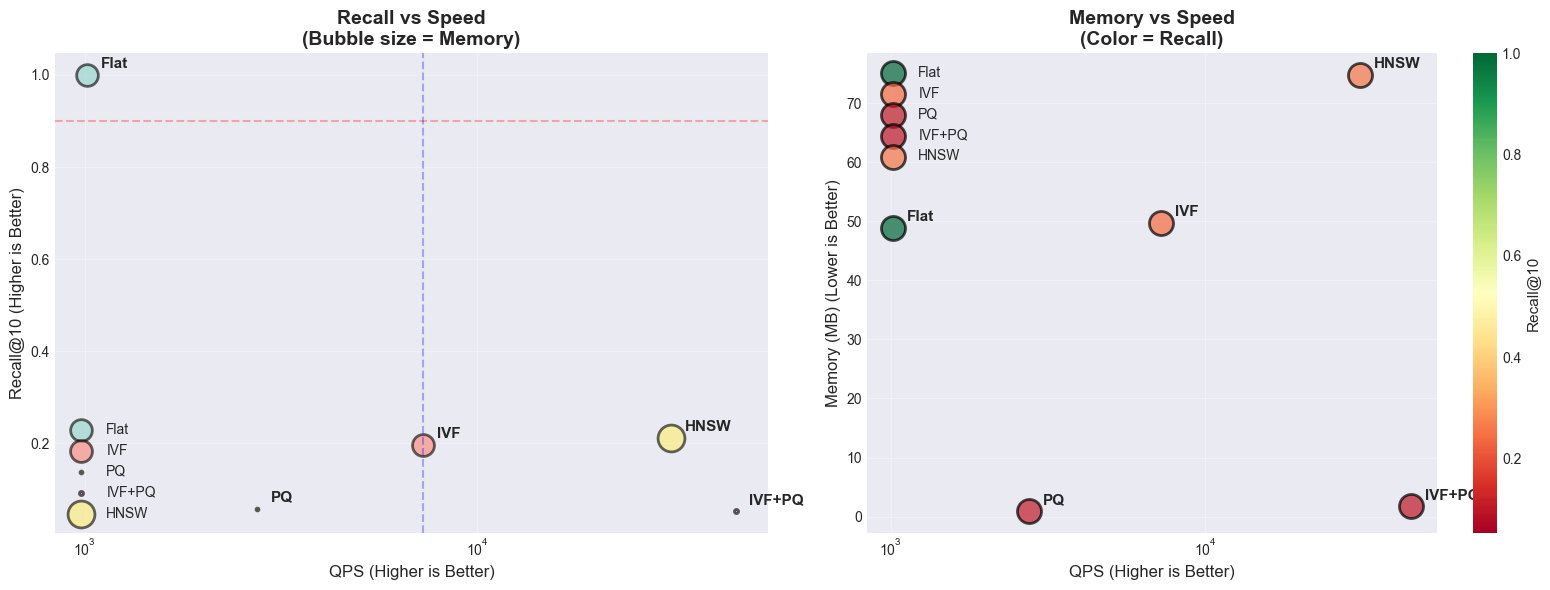

✓ Đã lưu: 03_pareto_analysis.png


In [9]:
# Analyze Pareto optimal indexes
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Recall vs Speed
ax = axes[0]
for i, name in enumerate(index_names):
    x = results[name]['qps']
    y = results[name]['recall']
    size = results[name]['size_mb']
    
    ax.scatter(x, y, s=size*5, alpha=0.6, color=colors[i], 
               edgecolors='black', linewidth=2, label=name)
    ax.annotate(name, (x, y), xytext=(10, 5), 
                textcoords='offset points', fontsize=11, fontweight='bold')

ax.set_xlabel('QPS (Higher is Better)', fontsize=12)
ax.set_ylabel('Recall@10 (Higher is Better)', fontsize=12)
ax.set_title('Recall vs Speed\n(Bubble size = Memory)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add quadrant lines
ax.axhline(0.9, color='red', linestyle='--', alpha=0.3, label='90% recall')
ax.axvline(np.median(qps_values), color='blue', linestyle='--', alpha=0.3)

# Plot 2: Memory vs Speed
ax = axes[1]
for i, name in enumerate(index_names):
    x = results[name]['qps']
    y = results[name]['size_mb']
    recall = results[name]['recall']
    
    # Color by recall
    color_val = plt.cm.RdYlGn(recall)
    ax.scatter(x, y, s=300, alpha=0.7, color=color_val,
               edgecolors='black', linewidth=2, label=name)
    ax.annotate(name, (x, y), xytext=(10, 5),
                textcoords='offset points', fontsize=11, fontweight='bold')

ax.set_xlabel('QPS (Higher is Better)', fontsize=12)
ax.set_ylabel('Memory (MB) (Lower is Better)', fontsize=12)
ax.set_title('Memory vs Speed\n(Color = Recall)', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, 
                           norm=plt.Normalize(vmin=min(recalls), vmax=max(recalls)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Recall@10', fontsize=11)

plt.tight_layout()
plt.savefig('03_pareto_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 03_pareto_analysis.png")

## 9. Decision Tree - Which Index to Use?

/tmp/ipykernel_27216/4022747183.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_27216/4022747183.py:64: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_27216/4022747183.py:64: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_27216/4022747183.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('03_decision_guide.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_27216/4022747183.py:65: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('03_decision_guide.png', dpi=300, bbox_inches='tight')
/tmp/ipykernel_27216/4022747183.py:65: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans Mono.
  plt.savefig('03_decision_guide.png', dpi=300, bbox_inch

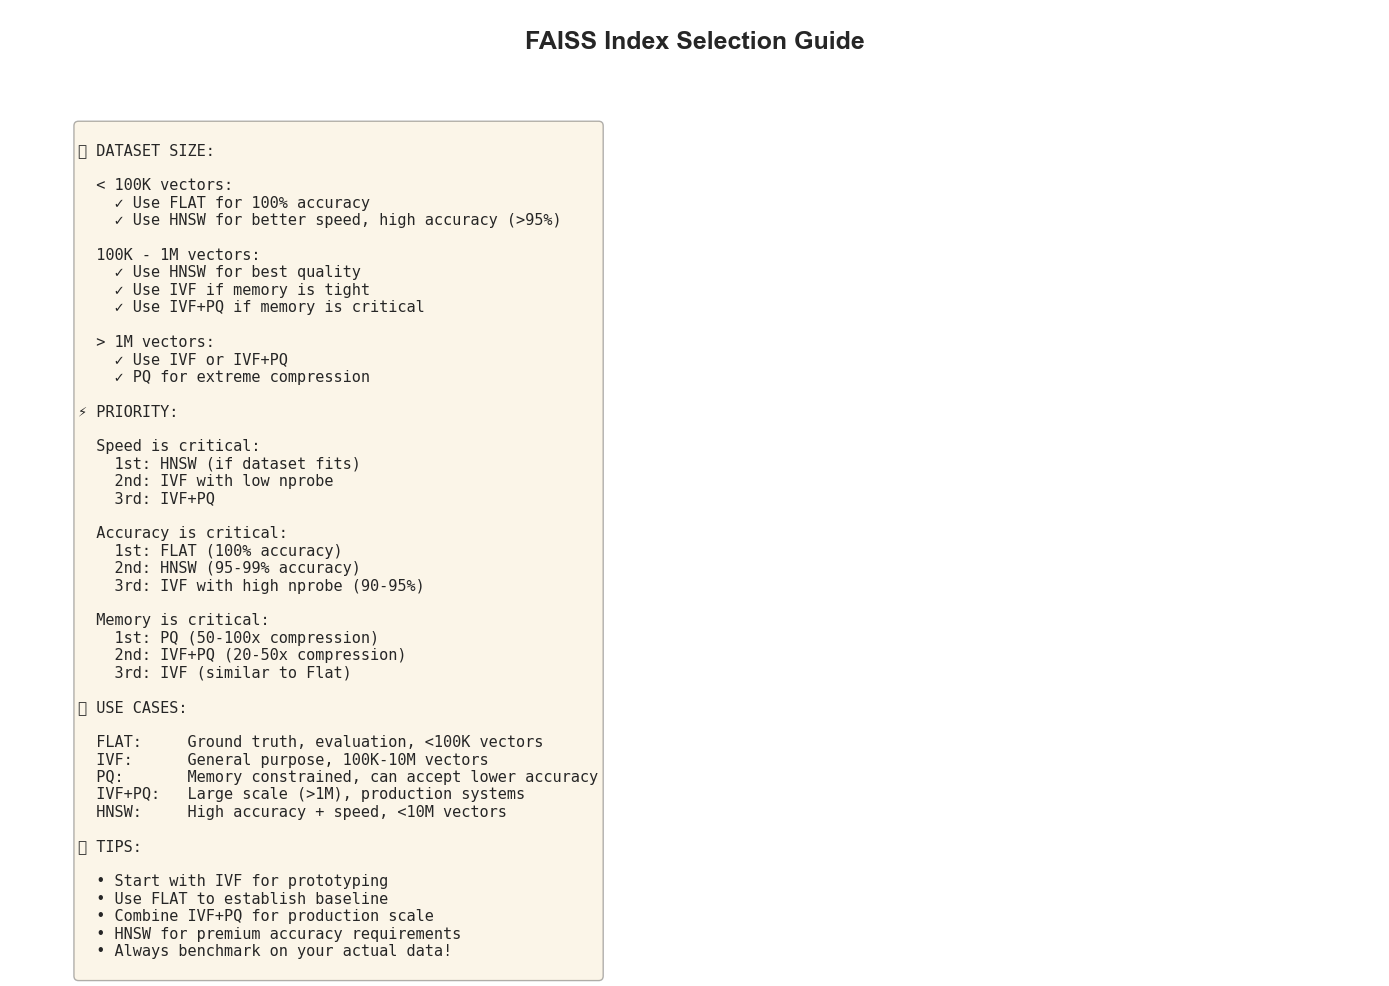

✓ Đã lưu: 03_decision_guide.png


In [10]:
# Create decision guide visualization
fig, ax = plt.subplots(figsize=(14, 10))
ax.axis('off')

# Title
ax.text(0.5, 0.95, 'FAISS Index Selection Guide', 
        ha='center', fontsize=18, fontweight='bold')

# Decision tree text
decision_text = """
📊 DATASET SIZE:

  < 100K vectors:
    ✓ Use FLAT for 100% accuracy
    ✓ Use HNSW for better speed, high accuracy (>95%)

  100K - 1M vectors:
    ✓ Use HNSW for best quality
    ✓ Use IVF if memory is tight
    ✓ Use IVF+PQ if memory is critical

  > 1M vectors:
    ✓ Use IVF or IVF+PQ
    ✓ PQ for extreme compression

⚡ PRIORITY:

  Speed is critical:
    1st: HNSW (if dataset fits)
    2nd: IVF with low nprobe
    3rd: IVF+PQ

  Accuracy is critical:
    1st: FLAT (100% accuracy)
    2nd: HNSW (95-99% accuracy)
    3rd: IVF with high nprobe (90-95%)

  Memory is critical:
    1st: PQ (50-100x compression)
    2nd: IVF+PQ (20-50x compression)
    3rd: IVF (similar to Flat)

🎯 USE CASES:

  FLAT:     Ground truth, evaluation, <100K vectors
  IVF:      General purpose, 100K-10M vectors
  PQ:       Memory constrained, can accept lower accuracy
  IVF+PQ:   Large scale (>1M), production systems
  HNSW:     High accuracy + speed, <10M vectors

💡 TIPS:

  • Start with IVF for prototyping
  • Use FLAT to establish baseline
  • Combine IVF+PQ for production scale
  • HNSW for premium accuracy requirements
  • Always benchmark on your actual data!
"""

ax.text(0.05, 0.85, decision_text, 
        ha='left', va='top', fontsize=11, family='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.savefig('03_decision_guide.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Đã lưu: 03_decision_guide.png")

## 10. Summary và Recommendations

In [11]:
print("="*90)
print("FINAL SUMMARY AND RECOMMENDATIONS".center(90))
print("="*90)

# Find best for each metric
best_recall = max(results.items(), key=lambda x: x[1]['recall'])
best_speed = max(results.items(), key=lambda x: x[1]['qps'])
best_memory = min(results.items(), key=lambda x: x[1]['size_mb'])
best_build = min(results.items(), key=lambda x: x[1]['build_time'])

print(f"\n🏆 WINNERS:")
print(f"  Best Recall:  {best_recall[0]:<10} ({best_recall[1]['recall']:.3f})")
print(f"  Best Speed:   {best_speed[0]:<10} ({best_speed[1]['qps']:.0f} QPS)")
print(f"  Best Memory:  {best_memory[0]:<10} ({best_memory[1]['size_mb']:.2f} MB)")
print(f"  Best Build:   {best_build[0]:<10} ({best_build[1]['build_time']:.3f}s)")

# Calculate overall score (weighted)
print(f"\n📊 OVERALL SCORE (weighted):")
print(f"  Formula: 0.4*Recall + 0.3*Speed + 0.2*Memory + 0.1*Build")
print()

scores = {}
for name in index_names:
    # Normalize metrics
    norm_recall = results[name]['recall']
    norm_speed = results[name]['qps'] / max(r['qps'] for r in results.values())
    norm_memory = 1 - (results[name]['size_mb'] / max(r['size_mb'] for r in results.values()))
    norm_build = 1 - (results[name]['build_time'] / max(r['build_time'] for r in results.values()))
    
    score = 0.4*norm_recall + 0.3*norm_speed + 0.2*norm_memory + 0.1*norm_build
    scores[name] = score
    print(f"  {name:<10}: {score:.3f}")

best_overall = max(scores.items(), key=lambda x: x[1])
print(f"\n  🥇 Overall winner: {best_overall[0]} (score: {best_overall[1]:.3f})")

print(f"\n💡 KEY TAKEAWAYS:")
print(f"  1. FLAT: Perfect accuracy but doesn't scale")
print(f"  2. IVF: Great balance for most use cases")
print(f"  3. HNSW: Best quality when dataset fits in memory")
print(f"  4. PQ/IVF+PQ: For extreme scale and memory constraints")
print(f"  5. Always benchmark on YOUR data and requirements!")

print(f"\n" + "="*90)

                            FINAL SUMMARY AND RECOMMENDATIONS                             

🏆 WINNERS:
  Best Recall:  Flat       (1.000)
  Best Speed:   IVF+PQ     (45467 QPS)
  Best Memory:  PQ         (0.89 MB)
  Best Build:   Flat       (0.121s)

📊 OVERALL SCORE (weighted):
  Formula: 0.4*Recall + 0.3*Speed + 0.2*Memory + 0.1*Build

  Flat      : 0.575
  IVF       : 0.276
  PQ        : 0.321
  IVF+PQ    : 0.581
  HNSW      : 0.290

  🥇 Overall winner: IVF+PQ (score: 0.581)

💡 KEY TAKEAWAYS:
  1. FLAT: Perfect accuracy but doesn't scale
  2. IVF: Great balance for most use cases
  3. HNSW: Best quality when dataset fits in memory
  4. PQ/IVF+PQ: For extreme scale and memory constraints
  5. Always benchmark on YOUR data and requirements!

